In [2]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append(str(Path.cwd().parent/'scripts'))
from _helpers import to_datetime

In [3]:
root = Path.cwd().parent / "resources" / "live_data"

prices = []
bmus = []
timestamps = []

for fn in tqdm(os.listdir(root)):

    date, period = fn.split('_')
    date = to_datetime(date, period)

    files = os.listdir(root / fn)
    if 'elexon_bmus.csv' in files and 'price_stats.csv' in files:

        bmu = pd.read_csv(root / fn / 'elexon_bmus.csv', index_col=0)

        bmus.append(bmu[['PN']].rename(columns={'PN': date}))

        price = pd.read_csv(root / fn / 'price_stats.csv', index_col=0)
        prices.append(price.iloc[0,0])
        timestamps.append(date)

bmus = pd.concat(bmus, axis=1).T
prices = pd.Series(prices, timestamps)
ts = prices.index

100%|██████████| 8865/8865 [06:42<00:00, 22.03it/s] 


In [21]:
ests = pd.read_csv(Path.cwd().parent / 'resources' / 'bmu_cost_estimates.csv', index_col=0).iloc[:,0]
ests.sort_values()


DRAXX-2      41.698571
DRAXX-3      46.422813
DRAXX-1      49.903765
CORB-1       53.527418
KEAD-2       54.432913
               ...    
EXETR-2      93.598099
FDUNT-1      96.084616
BSPHM-1      97.708140
BURGH-1     100.791216
KILLPG-1    103.058255
Name: 0, Length: 117, dtype: float64

      STAY-2   price
0      436.0  207.22
1      436.0  202.61
2      427.0  195.73
3      427.0  192.31
4      433.0  191.77
...      ...     ...
8186     0.0  -65.02
8187     0.0  -69.58
8188     0.0  -71.33
8189     0.0  -72.97
8190     0.0  -73.24

[8191 rows x 2 columns]


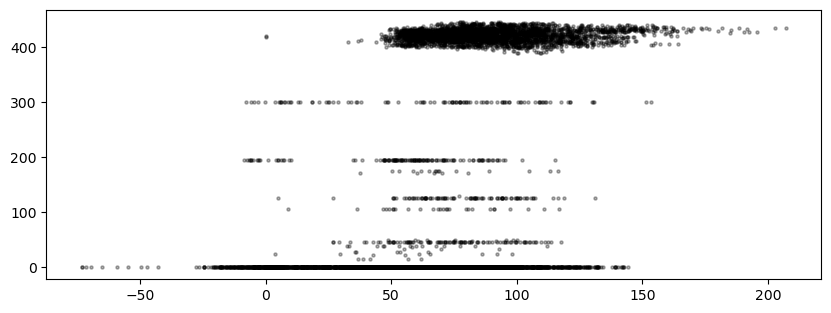

In [4]:
def bmu_analyis(dispatch, prices):

    assert (dispatch.index == prices.index).all()

    df = (
        pd.concat((dispatch, prices), axis=1)
        .rename(columns={0: 'price'})
        .sort_values(by='price', ascending=False)
    )
    df.index = range(len(df))

    fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

    print(df)
    ax.scatter(df.price.values, df.iloc[:,0], color='k', s=5, alpha=0.3)

    plt.show()


unit = "STAY-2"

bmu_analyis(bmus[unit], prices)


In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import argrelextrema

def get_extremes(dispatch, mode='on', neighbour_filter=10):
    """
    Returns indices of timeseries of dispatch in which a generator is switched on or off.
    Works for high-cost peak-demand meeting generators 
    
    Parameters
    ----------
    dispatch : pd.Series
        Timeseries of dispatch
    mode : str, optional
        'on' or 'off', by default 'on'; on to return times of on-switching else off-switching
    """

    if isinstance(dispatch, pd.DataFrame):
        assert len(dispatch.columns) == 0, 'unclear how to handle multiple columns in dispatch dataframe'
        dispatch = dispatch.iloc[:,0]

    if dispatch.max() > 1.:
        dispatch = pd.Series(
            MinMaxScaler().fit_transform(dispatch.values.reshape(-1, 1)).flatten(),
            index=dispatch.index
        )
    
    rounded = dispatch.fillna(0.).round()

    deriv_window_size = 10
    deriv = (
        rounded
        .rolling(deriv_window_size, center=True)
        .apply(lambda x: x[deriv_window_size//2:].mean() - x[:deriv_window_size//2].mean())
    )

    if mode == 'on':
        extreme_func = np.less_equal
    elif mode == 'off':
        extreme_func = np.greater_equal
    else:
        raise ValueError('mode must be either "on" or "off"')

    extremes = np.array(argrelextrema(deriv.values, extreme_func, order=5)[0])

    extremes = extremes[deriv.iloc[extremes] != 0]

    # minor cleanup; remove neighbouring values
    mask = np.abs(np.roll(extremes, 1) - extremes) < neighbour_filter
    mask = mask + np.roll(mask, -1)

    extremes = extremes[~mask]

    return extremes


def get_bmu_price_distribution(dispatch, prices, visval=False, **kwargs):

    full_index = pd.date_range(prices.index[0], prices.index[-1], freq='30T')

    prices = prices.copy().reindex(full_index).interpolate()
    dispatch = dispatch.copy().reindex(full_index).interpolate()

    dispatch = dispatch.loc[~dispatch.isna()]
    prices = prices.loc[dispatch.index]

    switchons = get_extremes(dispatch, mode='on', **kwargs)
    switchoffs = get_extremes(dispatch, mode='off', **kwargs)

    switchons = pd.Index([dispatch.index[n] for n in switchons])
    switchoffs = pd.Index([dispatch.index[n] for n in switchoffs])

    if visval:

        start = dispatch.index[0]
        if len(dispatch) > 1e3:
            end = dispatch.index[min(len(dispatch)-1, 1000)]

        fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
        ax.plot(dispatch, color='k')
        for on in switchons:
            ax.axvline(on, color='r', linestyle='--')
        for off in switchoffs:
            ax.axvline(off, color='b', linestyle='--')
        ax.set_title(dispatch.name)
        
        ax.set_xlim(start, end)

        ax.set_ylabel('Dispatch [MW]')
        ax.set_xlabel('Time')
        ax.xaxis.set_tick_params(rotation=45)

        plt.show()

    avg_prices = list()

    for on in switchons:

        try:
            off = switchoffs[switchoffs > on][0]
        except IndexError:
            continue

        avg_prices.append(prices.loc[on:off].mean())
    
    if len(avg_prices) == 0:
        return np.nan
    else:
        return avg_prices


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[  24  172  226  274  304  350  399  418  446  495  658  734  756  834
  948  992 1072 1120 1167 1215 1360 1408] [ 112  169  186  236  288  336  384  409  428  478  529  719  748  764
  861  958 1053 1104 1150 1196 1242 1391]
DatetimeIndex(['2023-10-04 08:00:00', '2023-10-05 12:30:00',
               '2023-10-05 21:00:00', '2023-10-06 22:00:00',
               '2023-10-08 00:00:00', '2023-10-09 00:00:00',
               '2023-10-10 00:00:00', '2023-10-10 12:30:00',
               '2023-10-10 22:00:00', '2023-10-11 23:00:00',
               '2023-10-13 00:30:00', '2023-10-16 23:30:00',
               '2023-10-17 14:00:00', '2023-10-17 22:00:00',
               '2023-10-19 22:30:00', '2023-10-21 23:00:00',
               '2023-10-23 22:30:00', '2023-10-25 00:00:00',
               '2023-10-25 23:00:00', '2023-10-26 22:00:00',
               '2023-10-27 21:00:00', '2023-10-30 23:30:00'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2023-10-02 12:00:00', '2023-10-05 14:

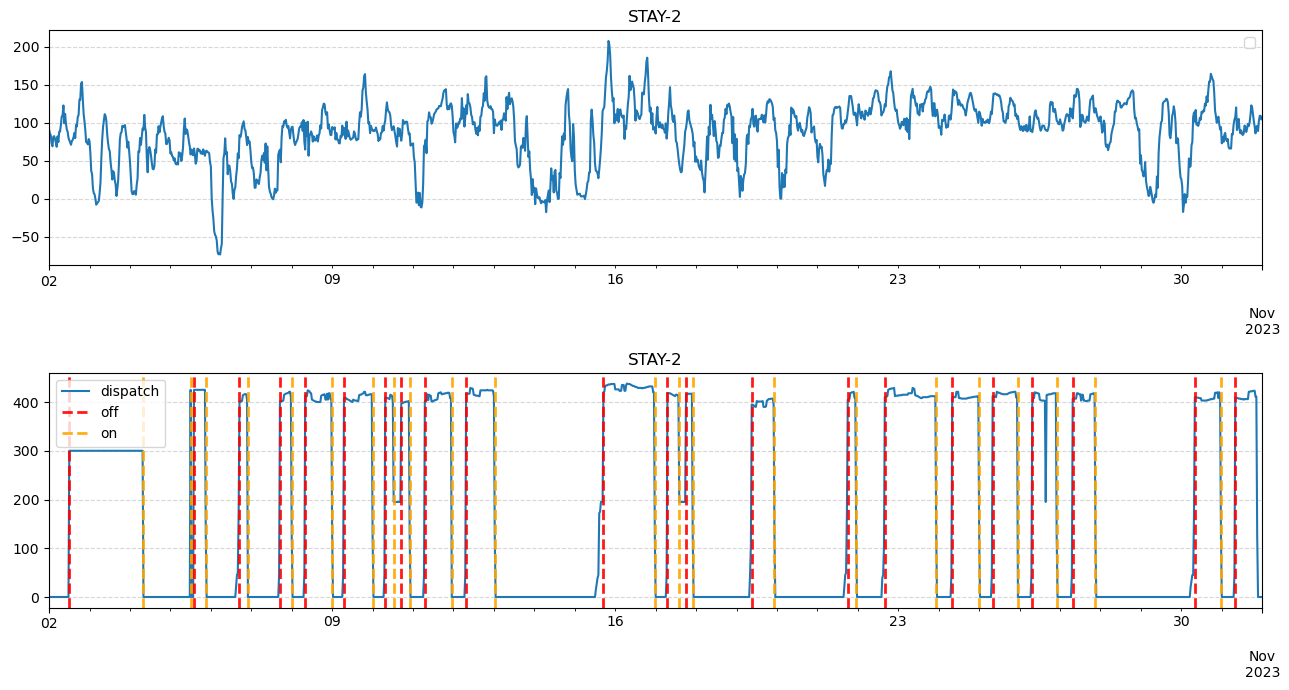

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(13, 7))

# full_index = pd.date_range(prices.index[0], prices.index[-1], freq='30T')
full_index = pd.date_range('2023-10-02', '2023-11-01', freq='30T')

prices.loc[full_index].plot(ax=axs[0])
p = bmus.loc[full_index, unit]

switchons = get_extremes(p, mode='on')
switchoffs = get_extremes(p, mode='off')

print(switchoffs, switchons)

p.plot(ax=axs[1], label='dispatch')

for i, n in enumerate(switchoffs):

    if i == 0:
        label = 'off'
    else:
        label = None
    axs[1].axvline(p.index[n], color='r', linestyle='--', alpha=0.9, label=label, linewidth=2)

for i, n in enumerate(switchons):

    if i == 0:
        label = 'on'
    else:
        label = None
    axs[1].axvline(p.index[n], color='orange', linestyle='--', alpha=0.9, label=label, linewidth=2)

switchons = pd.Index([p.index[n] for n in switchons])
switchoffs = pd.Index([p.index[n] for n in switchoffs])

print(switchons)
print(switchoffs)

for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    ax.set_title(unit)

# ax.set_xlim(full_index[0], full_index[1400])
plt.tight_layout()
plt.show()

In [7]:
bmu_data = pd.read_csv(Path.cwd().parent / 'resources' / 'bmunits_loc.csv', index_col=0)
print(bmu_data.carrier.unique())

[nan 'gas-fired' 'supply' 'battery' 'gas' 'onwind' 'hydro' 'hydro-scheme'
 'wind' 'biomass' 'offwind' 'CHP' 'CCGT' 'floating wind' 'oil' 'coal'
 'submarine power cable' 'gas turbine' 'powerstation' 'interconnector'
 'HVDC submarine' 'cascade' 'steel mill' 'business' 'PV' 'PHS' 'nuclear'
 'dam' 'solar power station' 'natural gas processing']


In [8]:
dispatchers = (
    (b := (
        pd.concat((
            bmu_data.loc[bmu_data.index.intersection(bmus.columns)],
            bmus.sum()
        ), axis=1)
        .rename(columns={0: 'generation'})
        .sort_values(by='generation', ascending=False)
    ))
    .loc[
        (b["carrier"].isin(['gas', 'CCGT', 'biomass', 'coal', 'CHP', 'gas turbine', 'powerstation']))
        & (b["generation"] > 0.)
    ]
)
total_generation = dispatchers.generation.sum()

In [293]:
dispatchers.loc[dispatchers.generation > 0.].tail(30)

,lat,lon,capacity,carrier,generation
WTRLN-1,0.000000,0.000000,19.0,powerstation,4150.0
FDUNT-1,53.071393,-1.349033,100.0,gas,3763.0
KILLPG-2,53.659520,-0.255110,600.0,CCGT,3658.0
BRIDU-1,54.086555,-0.203475,0.0,gas,3530.0
SOLUU-1,50.745900,-1.286400,0.0,gas,3161.0
TDRVE-1,0.000000,0.000000,6.0,gas,3037.0
ABERU-1,53.090486,-1.270137,10.0,gas,2877.0
SEVIU-1,51.587736,-2.998323,10.0,gas,2712.0
LSTWY-1,0.000000,0.000000,12.0,gas,2590.0
BURGH-1,0.000000,0.000000,45.0,gas,2390.0


HUMR-1     0.045667
DRAXX-2    0.088197
DRAXX-3    0.128029
MRWD-1     0.167774
DRAXX-1    0.203085
             ...   
GRAI1G     0.999996
GRAI4G     0.999998
DIDC01G    0.999998
DIDC02G    0.999999
DIDC03G    1.000000
Name: generation, Length: 117, dtype: float64

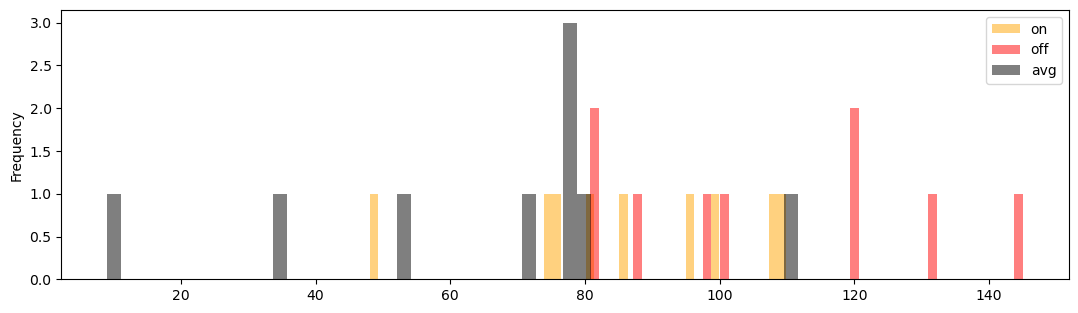

In [261]:
fig, ax = plt.subplots(1, 1, figsize=(13, 3.5))

prices.loc[switchons].plot.hist(ax=ax, bins=50, alpha=0.5, color='orange', label='on')
prices.loc[switchoffs].plot.hist(ax=ax, bins=50, alpha=0.5, color='r', label='off')
pd.Series(avg_prices).plot.hist(ax=ax, bins=50, alpha=0.5, color='k', label='avg')

ax.legend()
plt.show()

In [18]:
results = {}
# for unit in ["DRAXX-1", "STAY-2", "MRWD-1", "HUMR-1", "DIDCB5", "SPLN-1", "KEAD-2", "PEHE-1", "LAGA-1", "PEMB-51", "GRAI-7"]:
for unit in ['KILLPG-2']:

    print('dispatch')
    print(bmus[unit])
    print('prices')
    print(prices)
    print(type(prices))

    assert False

    results[unit] = pd.Series(get_bmu_price_distribution(bmus[unit], prices, visval=True, neighbour_filter=5))

fig, ax = plt.subplots(1, 1, figsize=(13, 3.5))
for unit in results:
    results[unit].plot.hist(ax=ax, bins=20, alpha=0.5, label=unit)
ax.legend()
plt.show()

dispatch
2023-10-01 01:00:00    0.0
2023-10-01 05:30:00    0.0
2023-10-01 06:00:00    0.0
2023-10-01 06:30:00    0.0
2023-10-01 07:00:00    0.0
                      ... 
2024-04-06 03:00:00    0.0
2024-04-06 03:30:00    0.0
2024-04-06 04:00:00    0.0
2024-04-06 04:30:00    0.0
2024-04-06 05:00:00    0.0
Name: KILLPG-2, Length: 8191, dtype: float64
prices
2023-10-01 01:00:00    97.26
2023-10-01 05:30:00    72.37
2023-10-01 06:00:00    84.38
2023-10-01 06:30:00    84.28
2023-10-01 07:00:00    82.16
                       ...  
2024-04-06 03:00:00     6.28
2024-04-06 03:30:00    -8.80
2024-04-06 04:00:00   -14.67
2024-04-06 04:30:00   -17.55
2024-04-06 05:00:00   -19.86
Length: 8191, dtype: float64
<class 'pandas.core.series.Series'>


AssertionError: 

In [302]:
results

{'KILLPG-2': 0   NaN
 dtype: float64}

In [245]:
results['DRAXX-1']

0     77.459286
1     91.025849
2     92.023333
3     64.652963
4     62.090000
        ...    
58    63.555823
59    64.530667
60    63.026000
61    65.384182
62    67.425778
Length: 63, dtype: float64

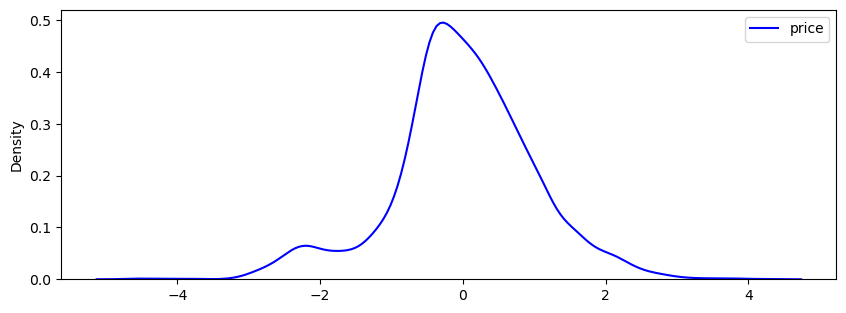

In [87]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

sns.kdeplot(StandardScaler().fit_transform(df[['price']]).flatten(), ax=ax, color='blue', label='price')

ax.legend()
plt.show()

In [79]:
df

,STAY-2,price
2023-10-15 20:00:00,436.0,207.22
2023-10-15 20:30:00,436.0,202.61
2023-11-29 17:30:00,427.0,195.73
2023-11-29 18:00:00,427.0,192.31
2023-11-29 18:30:00,433.0,191.77
...,...,...
2023-10-06 06:00:00,0.0,-65.02
2023-10-06 04:00:00,0.0,-69.58
2023-10-06 05:00:00,0.0,-71.33
2023-10-06 04:30:00,0.0,-72.97


In [235]:
bmus.sum().sort_values(ascending=False).head(20)

ISG-NDPL1    7076540.0
SIZB-1       4918697.0
SIZB-2       4893932.0
HUMR-1       4473836.0
HEYM28       4423082.0
HEYM27       4328471.0
DRAXX-2      4166520.0
TORN-2       4052568.0
TORN-1       4046135.0
DRAXX-3      3902254.0
MRWD-1       3893622.0
DRAXX-1      3459310.0
DIDCB5       3143481.0
SPLN-1       3116117.0
KEAD-2       2738880.0
IFG-VSAL1    2698133.0
PEHE-1       2593068.0
DRAXX-4      2545410.0
HRTL-1       2512158.0
LAGA-1       2490456.0
dtype: float64

#### Change spread of dispatchable BMU costs

In [1]:
import pypsa
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
costs = pd.read_csv(Path.cwd().parent / 'data' / 'bmu_cost_estimates.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\lukas\\OneDrive\\Desktop\\projects\\nodal\\LMP\\data\\bmu_cost_estimates.csv'